In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, brier_score_loss, classification_report,roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_sample_weight

In [46]:
df = pd.read_csv("/Users/hrishityelchuri/Desktop/github/grabhack/driver-credit-scoring-engine/data/processed/df_feature_engineered.csv")

In [47]:
features = [
    'role','gender','age_group','city_tier',
    'earnings_avg',
    'on_time_rate','cancel_rate','customer_rating',
    'complaints','accidents','night_shift_pct','cashless_ratio',
    'wallet_txn_volume','past_due_history',
    'vehicle_age_bin','earnings_cv','productivity_stability',
    'earnings_stability','wallet_txn_bin',
    'tenure_x_earnings','active_x_reliability'
]

target = "good_repayment"

In [48]:
categorical_cols = ['role','gender','age_group','city_tier','vehicle_age_bin','wallet_txn_bin']
numerical_cols = [col for col in features if col not in categorical_cols]

In [49]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [51]:
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",   # handles imbalance
        random_state=42
    ))
])

In [52]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [53]:
def reweight_samples(df, sensitive_col="city_tier"):
    group_counts = df[sensitive_col].value_counts()
    weights = df[sensitive_col].map(lambda x: 1.0 / group_counts[x])
    return (weights / weights.mean()).values

w_train = reweight_samples(X_train, sensitive_col="city_tier")

In [54]:
clf.fit(X_train, y_train, classifier__sample_weight=w_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [55]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        86
           1       0.95      1.00      0.97      1514

    accuracy                           0.95      1600
   macro avg       0.47      0.50      0.49      1600
weighted avg       0.90      0.95      0.92      1600



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

In [56]:
y_prob = clf.predict_proba(X_test)[:, 1]

In [57]:
# 1. AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {auc:.3f}")

# 2. KS Statistic
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
ks_stat = max(tpr - fpr)
print(f"KS Statistic: {ks_stat:.3f}")

# 3. Gini Coefficient
gini = 2 * auc - 1
print(f"Gini Coefficient: {gini:.3f}")

# 4. Decile-wise lift analysis
df_lift = pd.DataFrame({"y_true": y_test, "y_prob": y_prob})
df_lift["decile"] = pd.qcut(df_lift["y_prob"], 10, labels=False)

decile_summary = df_lift.groupby("decile").agg(
    total=("y_true", "count"),
    events=("y_true", "sum")
).sort_index(ascending=False)
decile_summary["event_rate"] = decile_summary["events"] / decile_summary["total"]
print("\nDecile-wise lift analysis:")
print(decile_summary)

AUC-ROC: 0.577
KS Statistic: 0.154
Gini Coefficient: 0.155

Decile-wise lift analysis:
        total  events  event_rate
decile                           
9         109     105    0.963303
8         210     202    0.961905
7         113     109    0.964602
6         195     181    0.928205
5         109     102    0.935780
4         193     189    0.979275
3         159     149    0.937107
2         168     164    0.976190
1         166     152    0.915663
0         178     161    0.904494


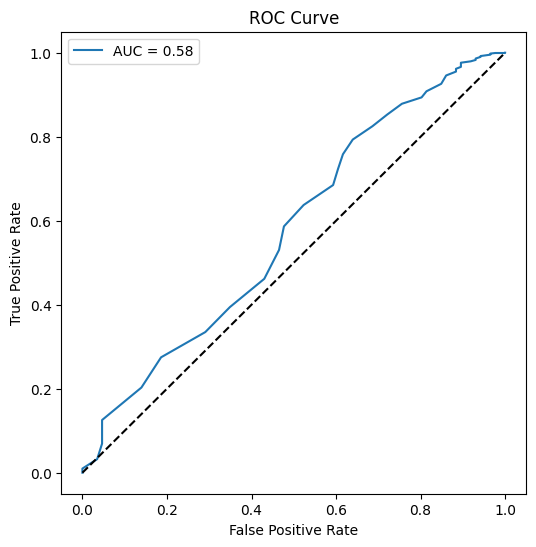

In [58]:
#Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

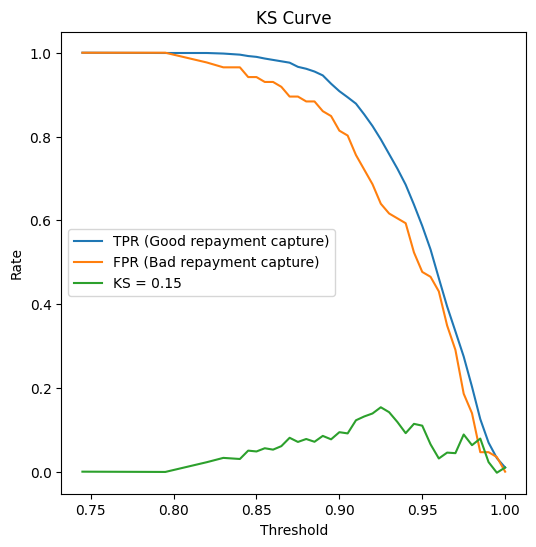

In [59]:
# Plot KS curve
plt.figure(figsize=(6,6))
plt.plot(thresholds, tpr, label="TPR (Good repayment capture)")
plt.plot(thresholds, fpr, label="FPR (Bad repayment capture)")
plt.plot(thresholds, tpr - fpr, label=f"KS = {ks_stat:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("KS Curve")
plt.legend()
plt.show()